<img src="../squeemos_blk.png" width=200 height=200 />

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil

from mpl_toolkits.basemap import Basemap

from BetterMap import CreateMapBackground

import math

import functools
import operator

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

## Clustering functions

In [2]:
# Return kmeans cluster centers of the given dataframe
def cluster_df(df):
    if df.shape[0] > 0:
        num_clusters = 5
        if df.shape[0] < num_clusters:
            num_clusters = df.shape[0]
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
        kmeans.fit(df[['Lat', 'Long']])
        df['cluster_label'] = kmeans.fit_predict(df[['Lat', 'Long']])
        centers = kmeans.cluster_centers_
        return centers
    result = np.empty((2,1))
    result[:] = np.NaN
    return result

#These 3 functions finds clustered centers of specific parts of the storm
def create_inner_df(df):
    centers = []
    df_inner_temp = df.copy()
    df_inner_temp = df_inner_temp[df_inner_temp['distance'] <= 100]
    end = df_inner_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_inner = df.copy()
        df_inner = df_inner[(df_inner['distance'] <= 100) & (df_inner['cluster'] == current_chunk)]
        centers.append(cluster_df(df_inner))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def create_rainband_df(df):
    centers = []
    df_rainband_temp = df.copy()
    df_rainband_temp = df_rainband_temp[(df_rainband_temp['distance'] >= 200) & (df_rainband_temp['distance'] <= 400)]
    end = df_rainband_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_rainband = df.copy()
        df_rainband = df_rainband[(df_rainband['distance'] >= 200) & (df_rainband['distance'] <= 400)]
        centers.append(cluster_df(df_rainband))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

def create_outer_df(df):
    centers = []
    df_outer_temp = df.copy()
    df_outer_temp = df_outer_temp[(df_outer_temp['distance'] >= 400) & (df_outer_temp['distance'] <= 600)]
    end = df_outer_temp['cluster'].max()
    if math.isnan(end):
        end = 0
    for current_chunk in range(1,int(end)):
        df_outer = df.copy()
        df_outer = df_outer[(df_outer['distance'] >= 400) & (df_outer['distance'] <= 600)]
        centers.append(cluster_df(df_outer))
    
    #flatten the list
    centers = functools.reduce(operator.iconcat, centers, [])
    #drop nan
    centers = [x for x in centers if str(x) != 'nan']
    return centers

## Data loading and verification

In [3]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

In [4]:
display(df.info())
display(df_center.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226789 entries, 0 to 226788
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year              226789 non-null  int64  
 1   Month             226789 non-null  int64  
 2   Day               226789 non-null  int64  
 3   Hour              226789 non-null  int64  
 4   Min               226789 non-null  int64  
 5   Sec               226789 non-null  float64
 6   Lat               226789 non-null  float64
 7   Long              226789 non-null  float64
 8   Dist_East_West    226789 non-null  float64
 9   Dist_North_South  226789 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 19.0 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          61 non-null     int64  
 1   Month         61 non-null     int64  
 2   Day           61 non-null     int64  
 3   Hour          61 non-null     int64  
 4   Lat           61 non-null     float64
 5   Long          61 non-null     float64
 6   Min_Pressure  61 non-null     int64  
 7   Max_Winds     61 non-null     int64  
 8   Unused        61 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 4.8 KB


None

In [5]:
#make a dataframe that denotes clusters based on a time interval - a new cluster every x amount of minutes
minutes_between = 30

def add_clusters_to_df(df, minutes_between):
    cluster = 0
    df_time = pd.DataFrame()
    df_time['cluster'] = 0
    for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                    temp['cluster'] = cluster
                    df_time = df_time.append(temp, ignore_index=True)
                    cluster+=1
    return df_time
df_time = add_clusters_to_df(df, minutes_between)
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cluster           230720 non-null  int64  
 1   Year              230720 non-null  float64
 2   Month             230720 non-null  float64
 3   Day               230720 non-null  float64
 4   Hour              230720 non-null  float64
 5   Min               230720 non-null  float64
 6   Sec               230720 non-null  float64
 7   Lat               230720 non-null  float64
 8   Long              230720 non-null  float64
 9   Dist_East_West    230720 non-null  float64
 10  Dist_North_South  230720 non-null  float64
 11  distance          230720 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


## Proof of concept/test with specific time

In [28]:
#apply date restriction
year, month, day, hour, minute = 2017, 8, 27, 18, 30

temp = df_time[(df_time['Year'] == year) &
                   (df_time['Month'] == month) &
                   (df_time['Day'] == day) &
                   (df_time['Hour'] == hour) &
                   (df_time['Min'] == minute)]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 440 to 457
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cluster           18 non-null     int64  
 1   Year              18 non-null     float64
 2   Month             18 non-null     float64
 3   Day               18 non-null     float64
 4   Hour              18 non-null     float64
 5   Min               18 non-null     float64
 6   Sec               18 non-null     float64
 7   Lat               18 non-null     float64
 8   Long              18 non-null     float64
 9   Dist_East_West    18 non-null     float64
 10  Dist_North_South  18 non-null     float64
 11  distance          18 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 1.8 KB


In [29]:
inner_clusters = create_inner_df(temp)
rainband_clusters = create_rainband_df(temp)
outer_clusters = create_outer_df(temp)

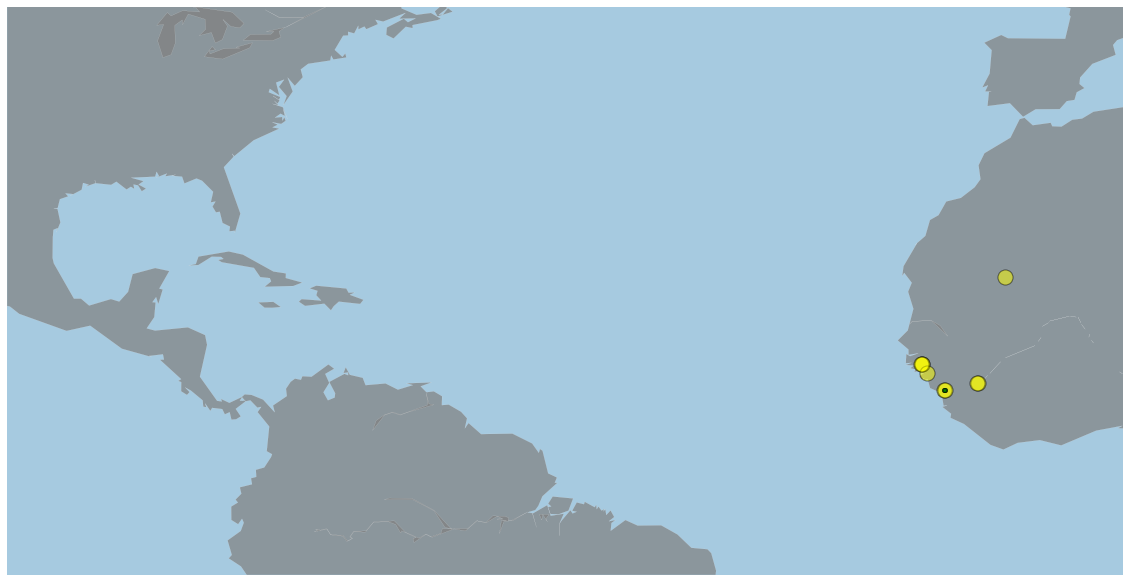

In [30]:
inner_centers = pd.DataFrame(data=inner_clusters, columns=["Lat", "Long"])
rainband_centers = pd.DataFrame(data=rainband_clusters, columns=["Lat", "Long"])
outer_centers = pd.DataFrame(data=outer_clusters, columns=["Lat", "Long"])

ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

plt.figure(figsize=(20,20))
m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# Plot the lightning data
m.plot(temp['Long'], temp['Lat'], linestyle='none', marker="o", markersize=15, alpha=0.3, c="yellow", markeredgecolor="black", markeredgewidth=1)
m.plot(inner_centers['Long'], inner_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="red", markeredgecolor="black", markeredgewidth=1)
m.plot(rainband_centers['Long'], rainband_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="green", markeredgecolor="black", markeredgewidth=1)
m.plot(outer_centers['Long'], outer_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="blue", markeredgecolor="black", markeredgewidth=1)

plt.show()

## Clustering to create a gif

In [26]:
ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
minLong_, minLat_, maxLong_, maxLat_ = ln['Long'].min(), ln['Lat'].min(), ln['Long'].max(), ln['Lat'].max()
buffer = 10

df_time = add_clusters_to_df(df, minutes_between)
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
display(df_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cluster           230720 non-null  int64  
 1   Year              230720 non-null  float64
 2   Month             230720 non-null  float64
 3   Day               230720 non-null  float64
 4   Hour              230720 non-null  float64
 5   Min               230720 non-null  float64
 6   Sec               230720 non-null  float64
 7   Lat               230720 non-null  float64
 8   Long              230720 non-null  float64
 9   Dist_East_West    230720 non-null  float64
 10  Dist_North_South  230720 non-null  float64
 11  distance          230720 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


None

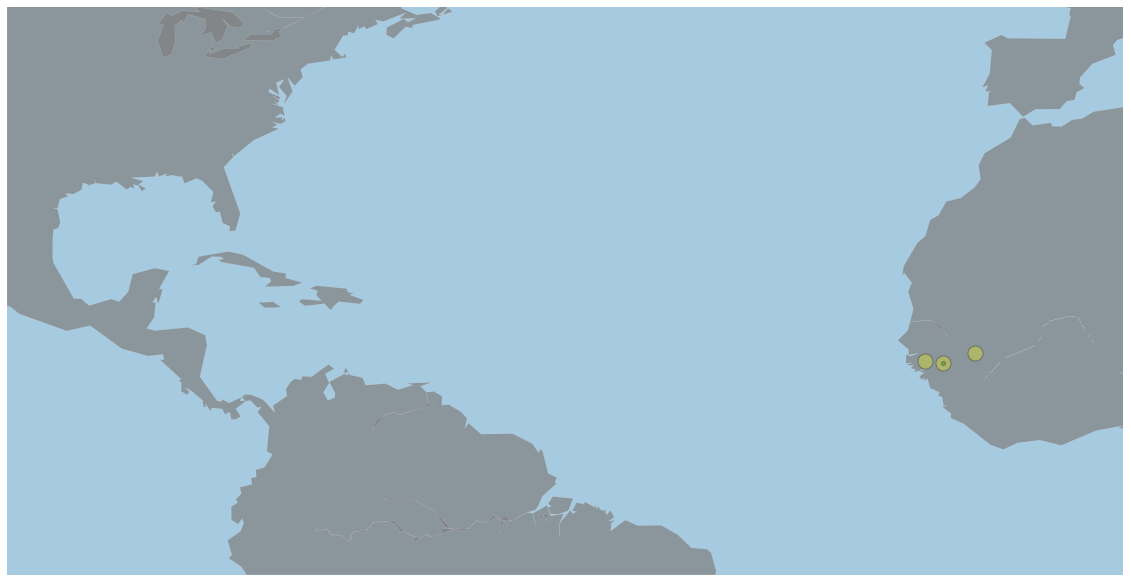

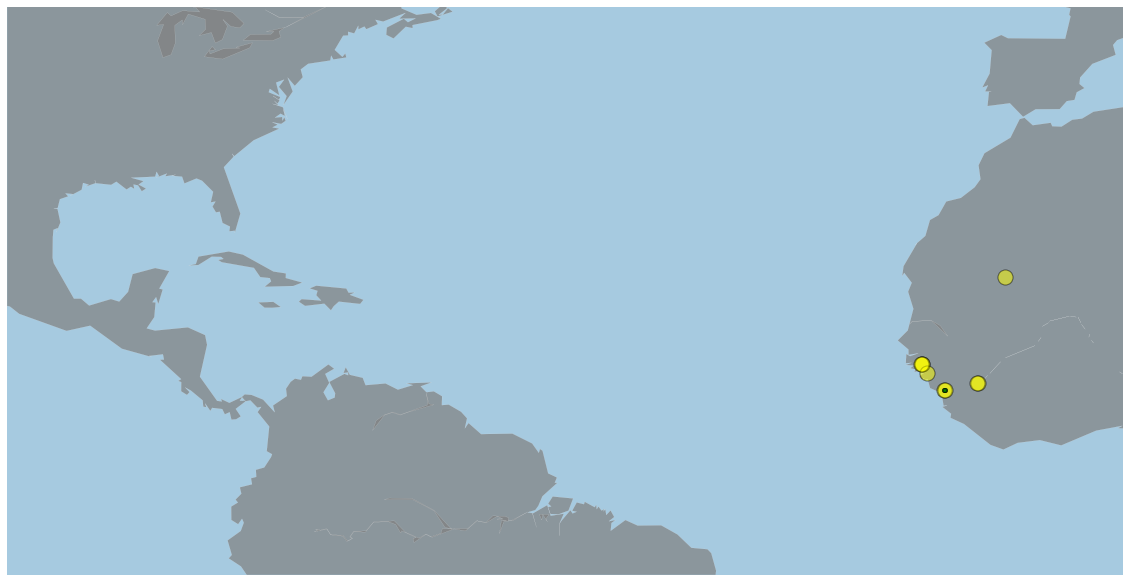

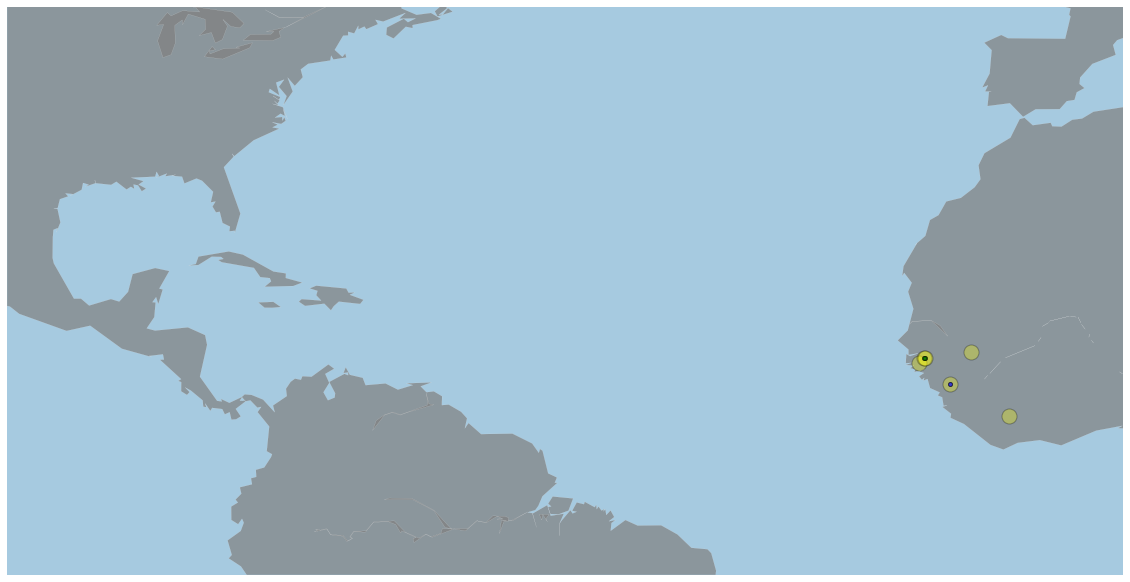

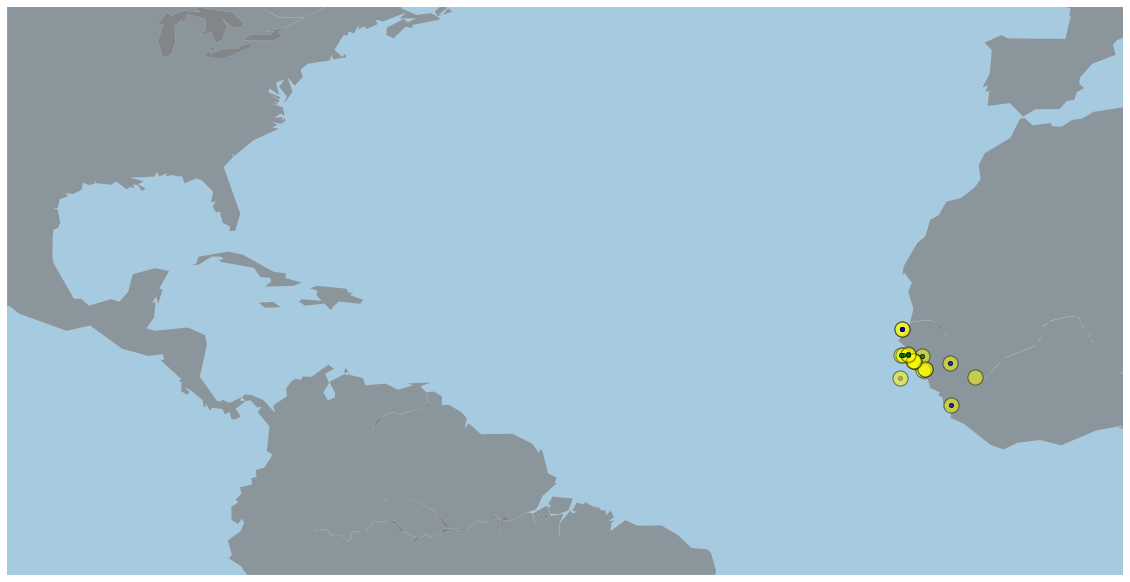

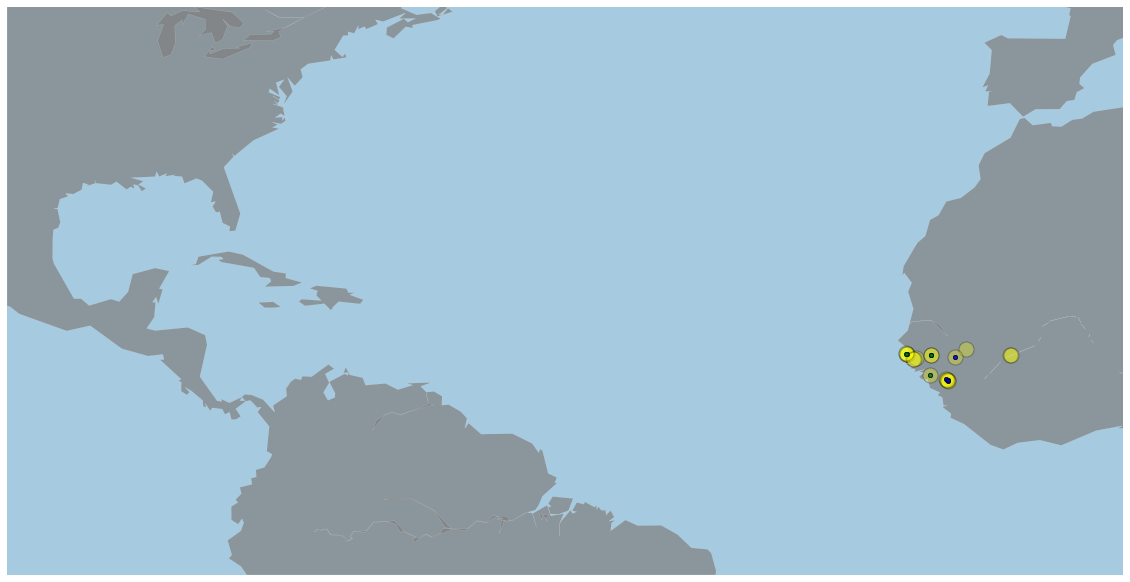

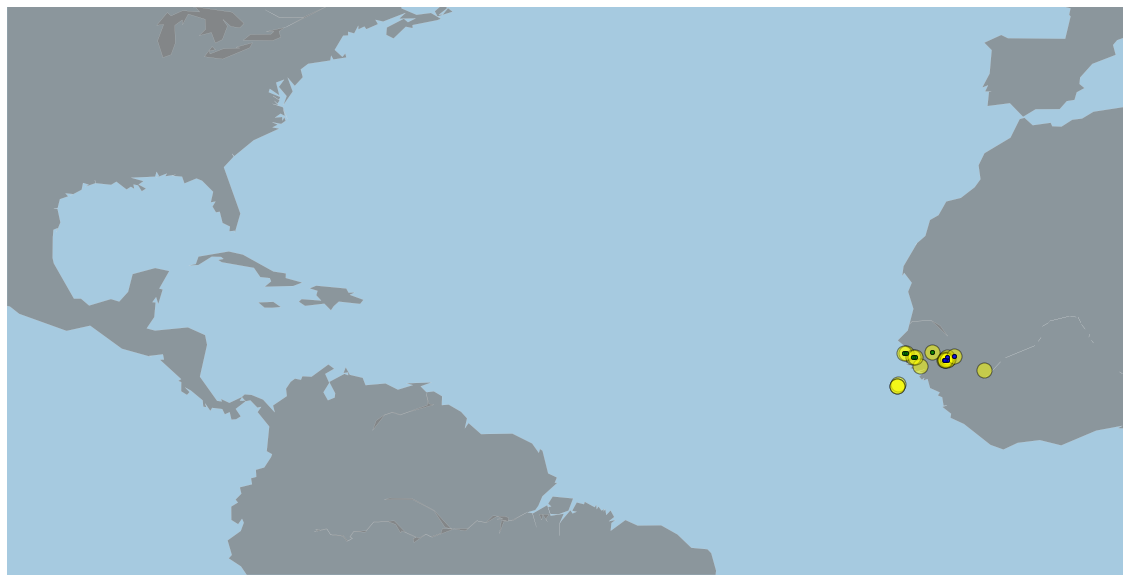

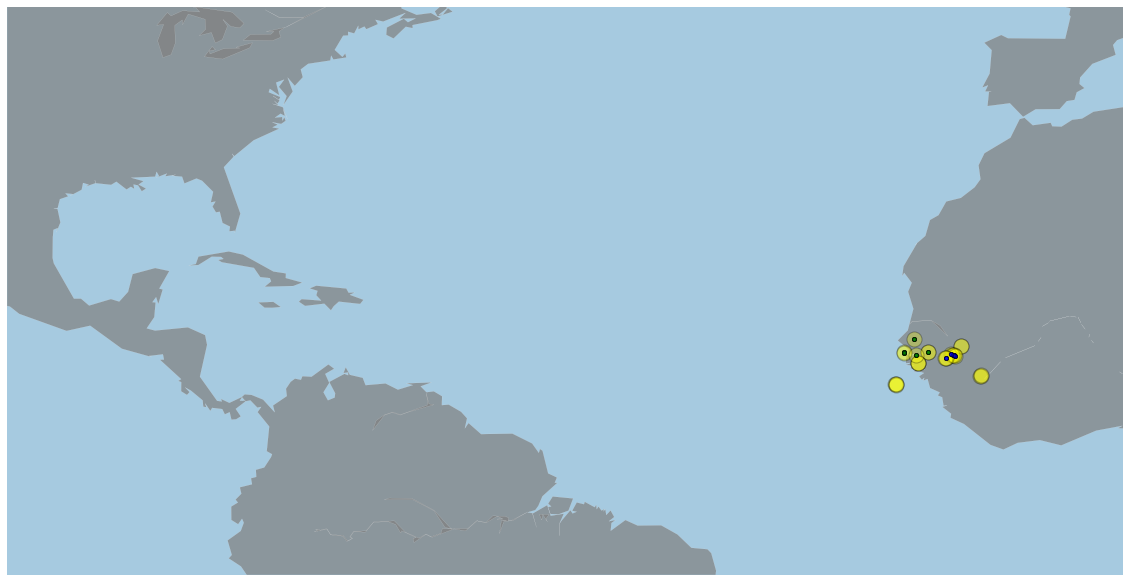

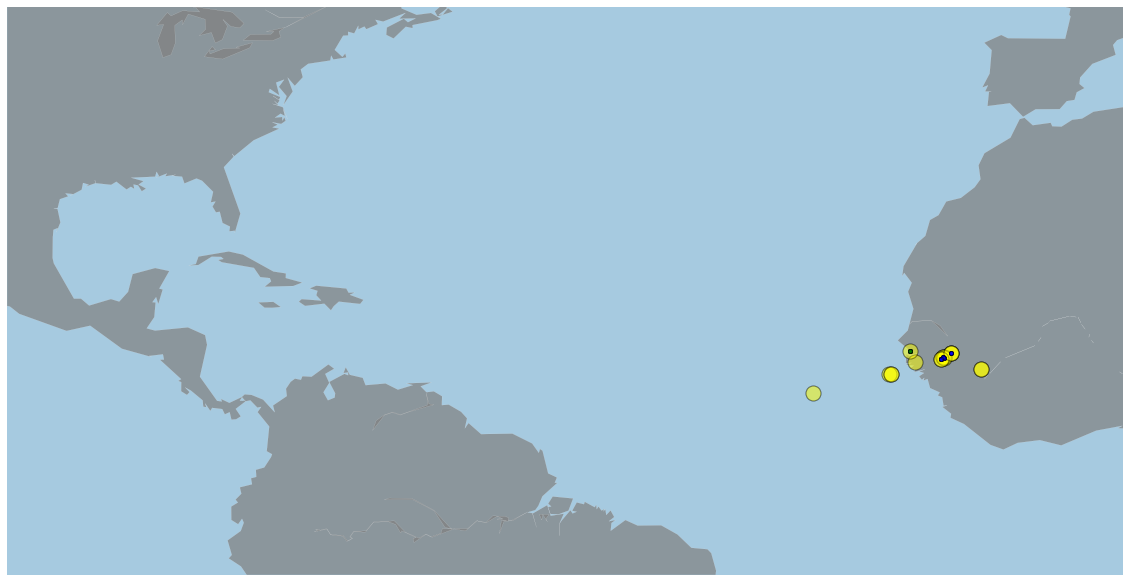

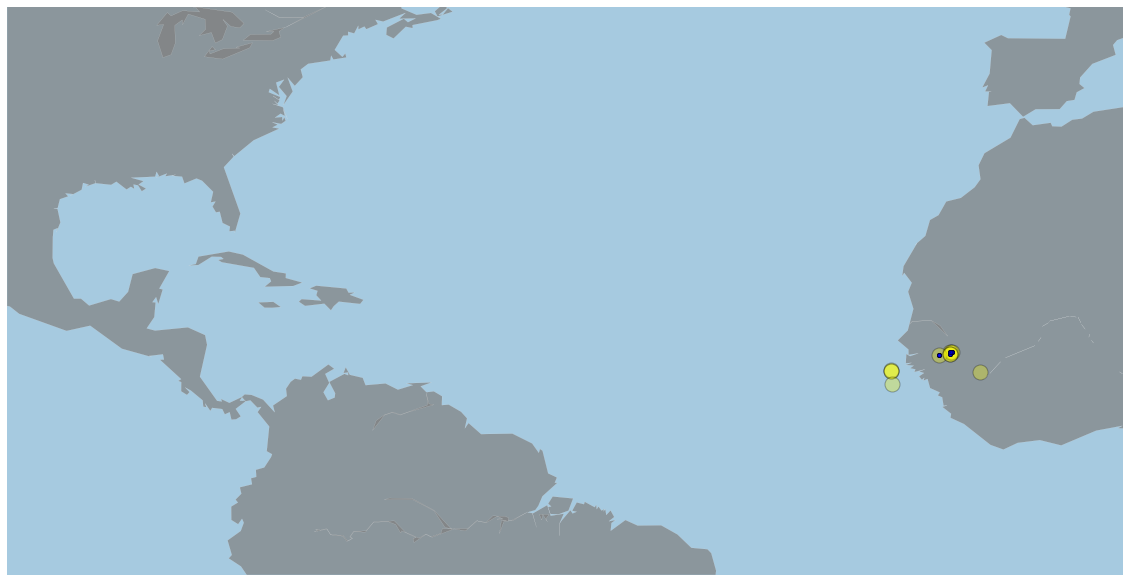

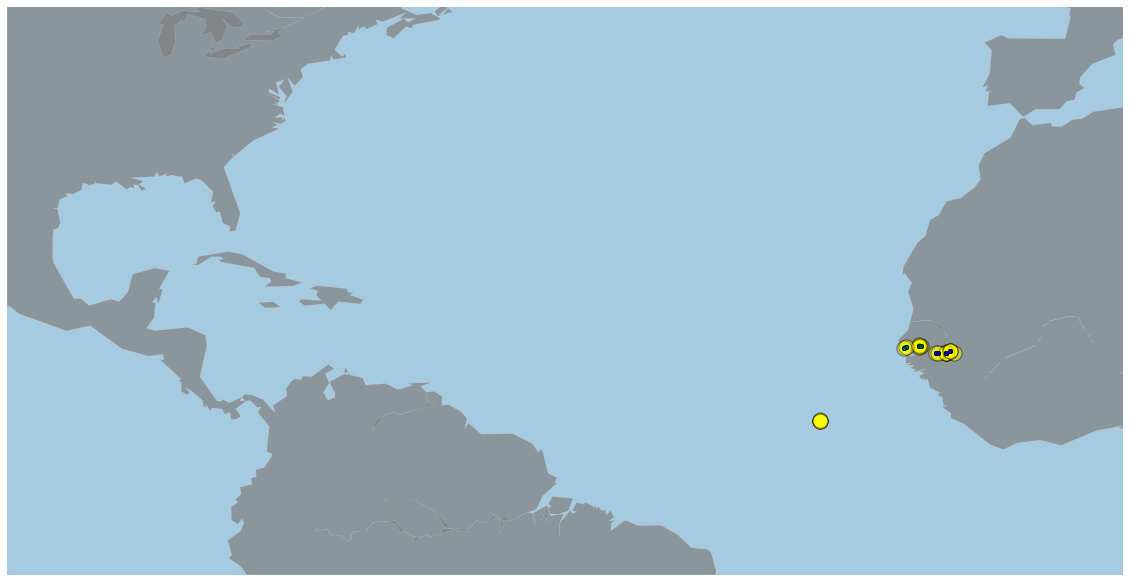

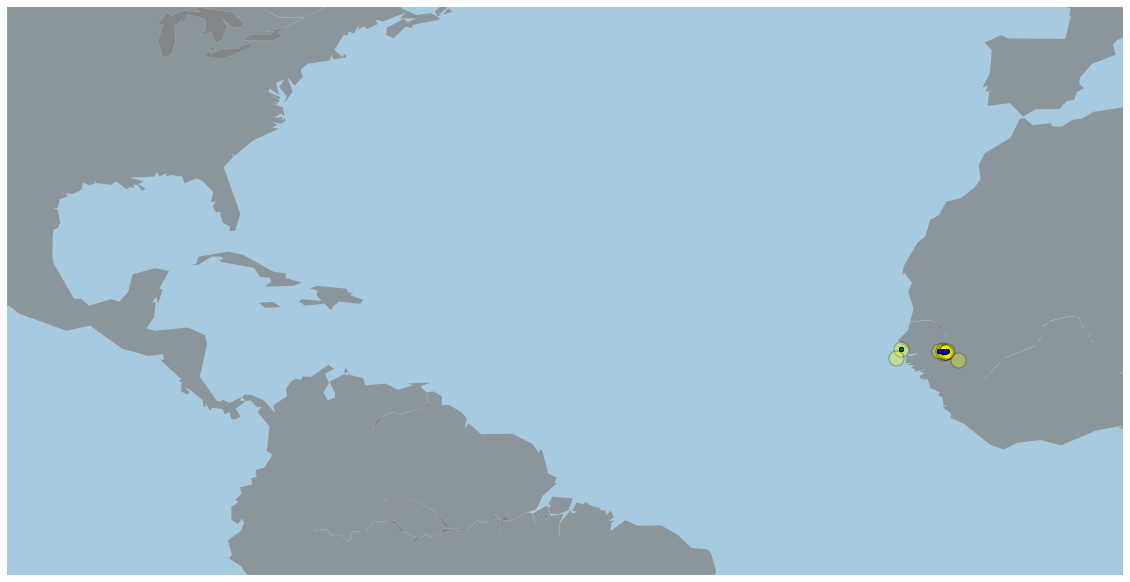

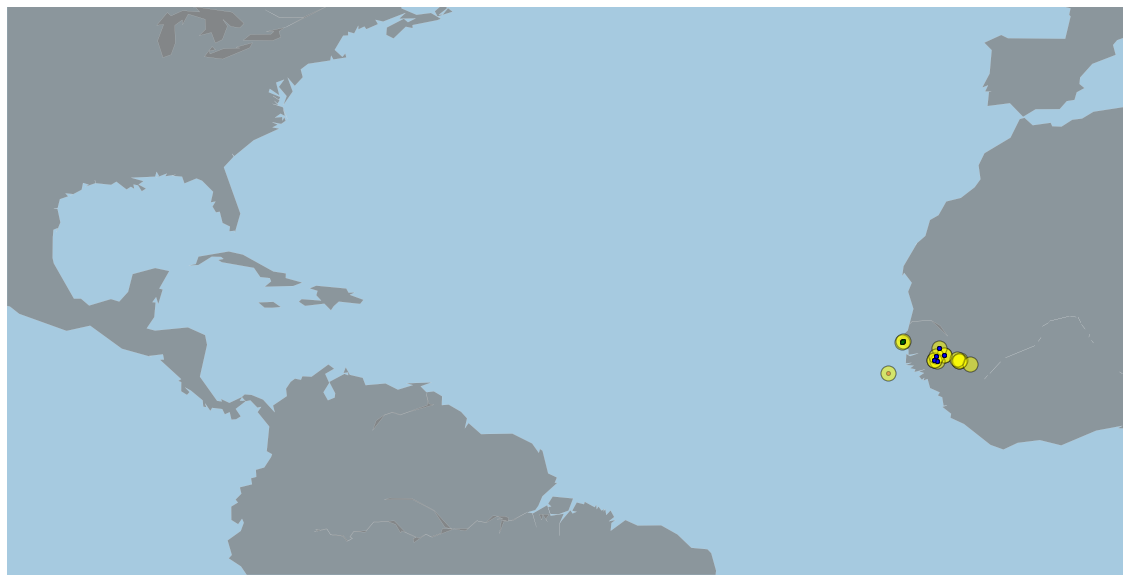

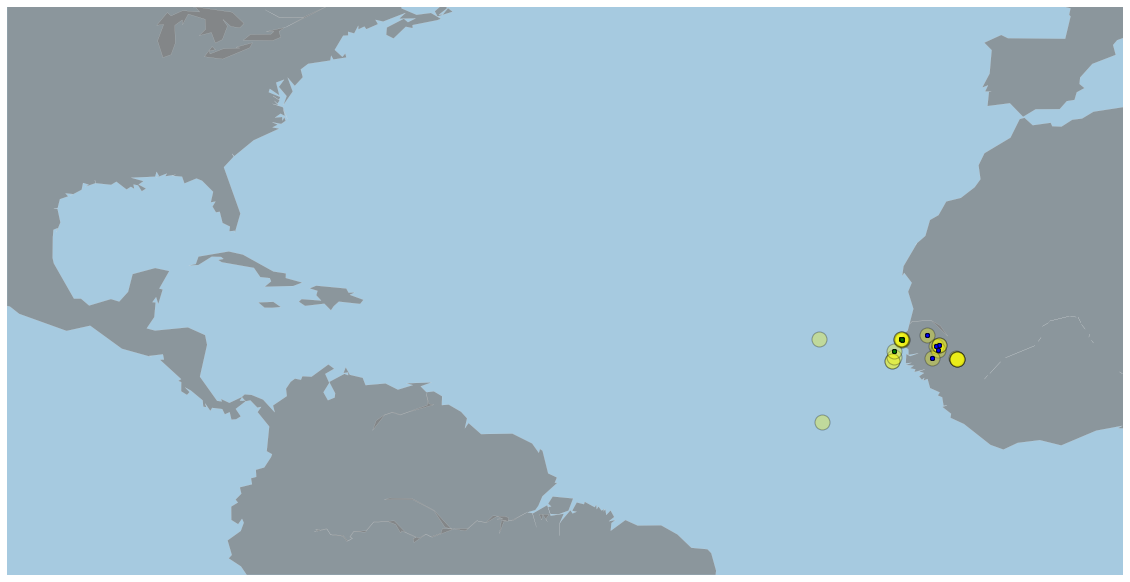

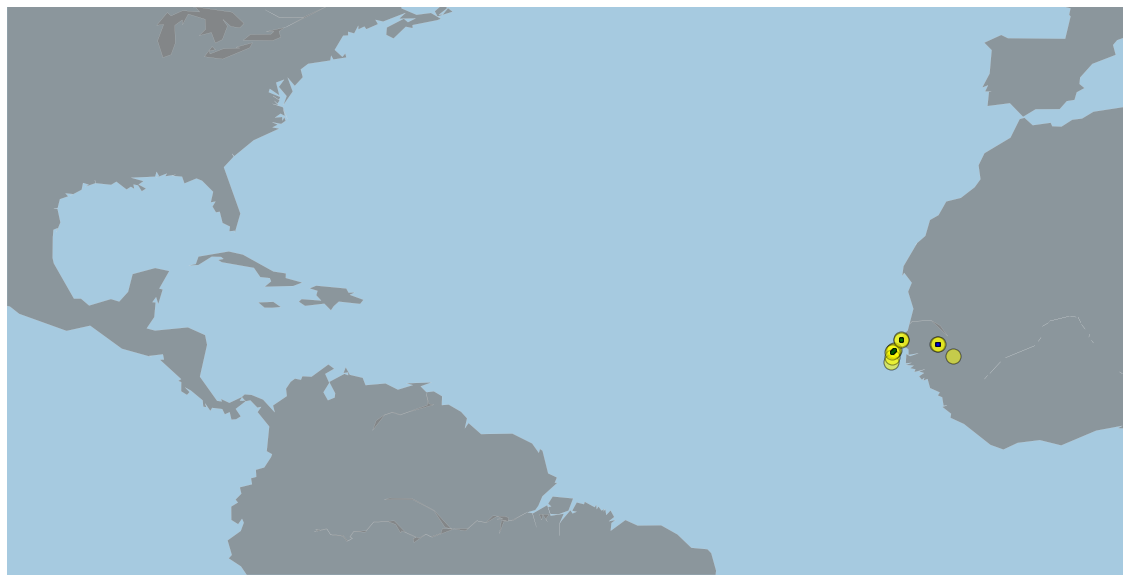

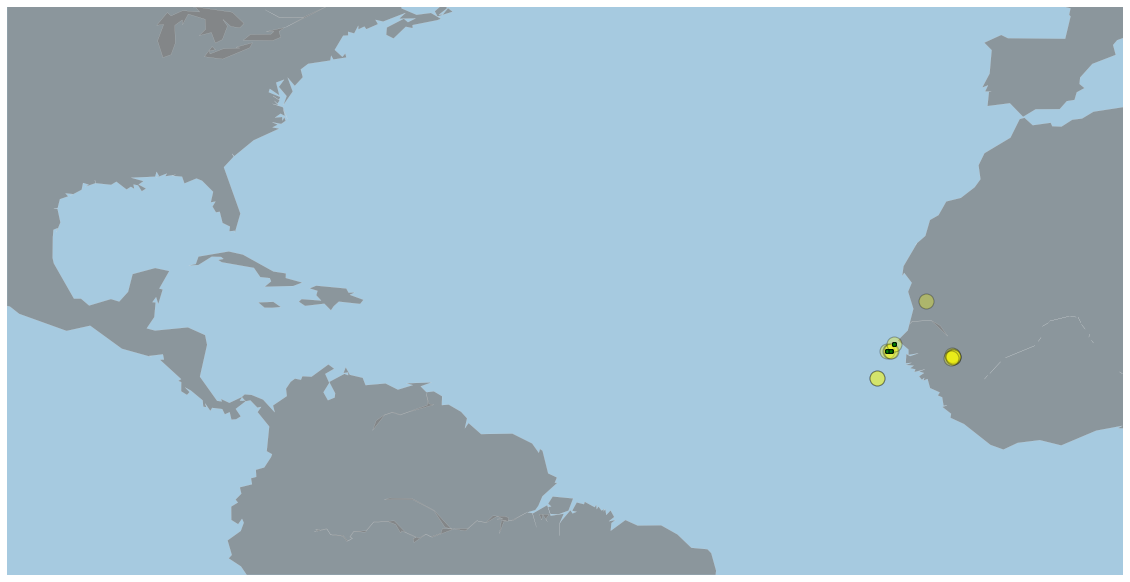

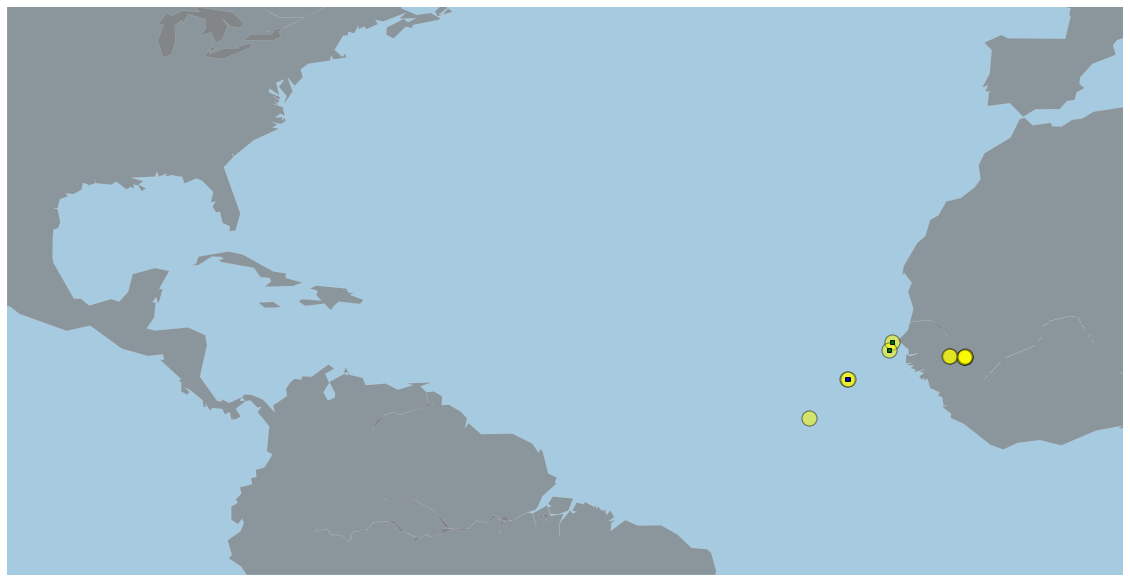

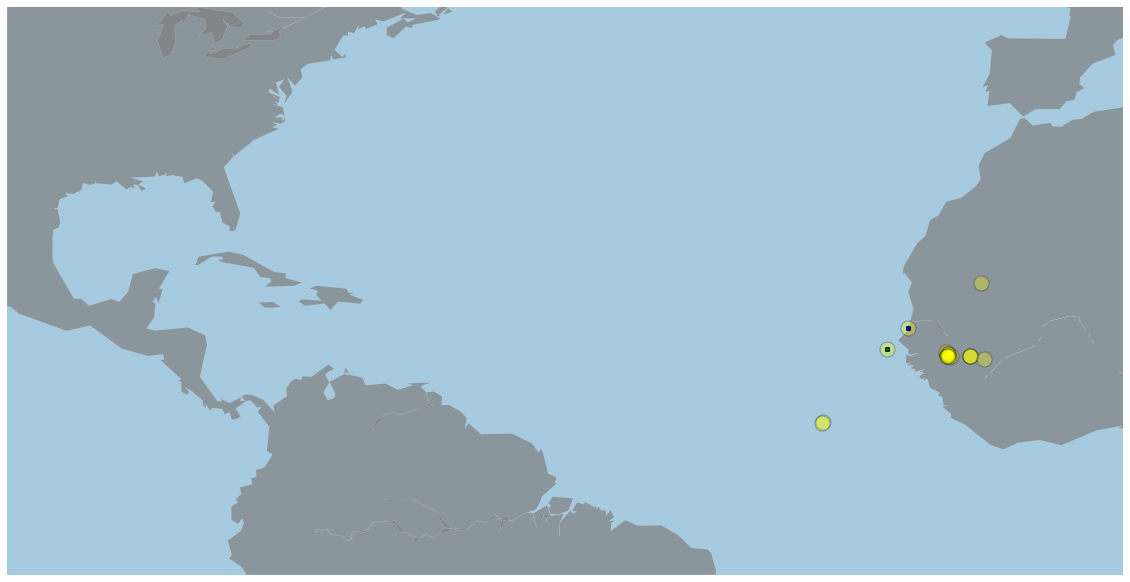

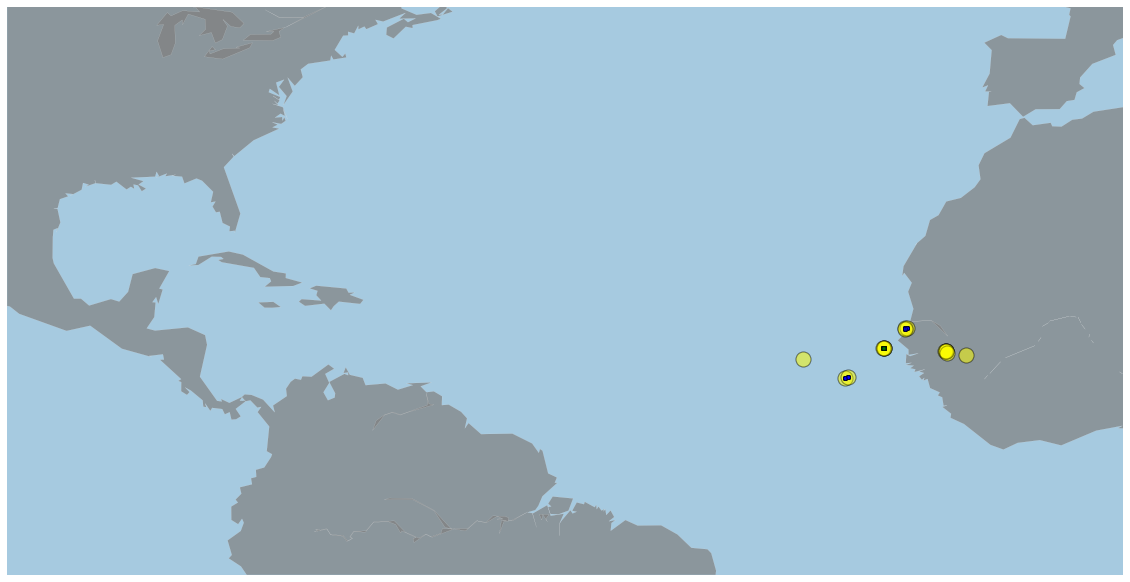

ValueError: 2 columns passed, passed data had 1 columns

In [31]:
year = 2017
for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df_time[(df_time['Year'] == year) &
                                       (df_time['Month'] == month) &
                                       (df_time['Day'] == day) &
                                       (df_time['Hour'] == hour) &
                                       (df_time['Min'] == minute)]
                    if(temp.shape[0] > 0):
                        inner_clusters = create_inner_df(temp)
                        rainband_clusters = create_rainband_df(temp)
                        outer_clusters = create_outer_df(temp)
                        
                        inner_centers = pd.DataFrame(data=inner_clusters, columns=["Lat", "Long"])
                        rainband_centers = pd.DataFrame(data=rainband_clusters, columns=["Lat", "Long"])
                        outer_centers = pd.DataFrame(data=outer_clusters, columns=["Lat", "Long"])
                        
                        plt.figure(figsize=(20,20))
                        m = Basemap(llcrnrlon=minLong_-buffer, llcrnrlat=minLat_-buffer,urcrnrlon=maxLong_+buffer,urcrnrlat=maxLat_+buffer,lon_0=0,lat_0=0)
                        m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
                        m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
                        m.drawcoastlines(linewidth=0.1, color="white")

                        # Plot the lightning data
                        m.plot(temp['Long'], temp['Lat'], linestyle='none', marker="o", markersize=15, alpha=0.3, c="yellow", markeredgecolor="black", markeredgewidth=1)
                        m.plot(inner_centers['Long'], inner_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="red", markeredgecolor="black", markeredgewidth=1)
                        m.plot(rainband_centers['Long'], rainband_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="green", markeredgecolor="black", markeredgewidth=1)
                        m.plot(outer_centers['Long'], outer_centers['Lat'], linestyle='none', marker=".", markersize=8, alpha=0.3, c="blue", markeredgecolor="black", markeredgewidth=1)

                        plt.show()

In [ ]:
#DEPRECATED
'''#elbow graph for visual estimation of ideal cluster count
clusters = range(1,16)

kmeans = [KMeans(n_clusters=i) for i in clusters]

y = df[['Lat']]
x = df[['Long']]

score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

plt.plot(clusters, score)

plt.show()'''

'''#kmeans using the set cluster count
kmeans = KMeans(n_clusters=4, init='k-means++')
cluster_df = coord_df
kmeans.fit(cluster_df)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)
inertia = kmeans.inertia_
labels = kmeans.predict(cluster_df[cluster_df.columns[:2]])
centers = kmeans.cluster_centers_

cluster_df.plot.scatter(x='Lat',y='Long', c=labels, s=50, cmap='spring', figsize=(20,20))
plt.scatter(centers[:, 0], centers[:, 1], c='black', s= 200, alpha=.5)

plt.show()'''

'''for n_clusters in range(1,16):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
        kmeans.fit(cluster_df)
        inertia = kmeans.inertia_
        print("Cluster count: ", n_clusters, "\tInertia: ", inertia)
        '''